# Tasks, Workflows and Flow

In this notebook we discuss some of the basic concepts used in AbiPy 
to automate ab-initio calculations. 
In particular we will focus on the following three objects: 

   * `Task`
   * `Work`
   * `Flow`
   
The `Task` represent the most *elementary step* of the automatic workflow. 
Roughly speaking, it corresponds to the execution of a single Abinit calculation **without** multiple datasets.

From the point of view of AbiPy, a calculation consists of a set of `Tasks` that are connected 
by dependencies. 
Each task has a list of files that are needed to start the calculation, 
and a list of files that are produced at the end of the run.

Some of the input files needed by a `Task` must be provided by the user in the form of Abinit input variables 
(e.g. the crystalline structure, the pseudopotentials), other inputs may be produced by other tasks.
When a `Task` **B** requires the output file `DEN` of another task **A**, 
we say that **B** depends on **A** through a `DEN` file, and we express this dependency with the dictionary:

```python
B_deps = {A: "DEN"}
```

To clarify this point, let's take a standard KS band structure calculation as an example.
In this case, we have an initial `ScfTask` that solves the KS equations self-consistently to produce a `DEN` file. 
The density is then used by a second `NscfTask` to compute a band structure on an arbitrary 
set of $k$-points.
The `NscfTask` thus has a dependency on the `ScfTask` in the sense that it cannot be executed 
until the `ScfTask` is completed and the `DEN` file is produced by the `ScfTask`.

Now that we have clarified the concept of `Task`, we can finally turn to `Works` and `Flow`.
The `Work` can be seen as a list of `Tasks`, while the `Flow` is essentially a list of `Work` objects.
Works are usually used to group tasks that are connected to each other.
Flows are the final objects that are executed. The `Flow` provides an easy-to-use
interface for performing this execution. 
The `Flow` provides a high-level API to perform common operations like launching the actual jobs, checking the status of the `Tasks`, correcting problems etc. 

AbiPy provides several tools to generate Flows for typical first-principles calculations, so called factory functions.
This means that you do not need to understand all the technical details of the python implementation.
In many cases, indeed, we already provide some kind of `Work` or `Flow` that automates 
your calculation, and you only need to provide the correct list of input files.
This list, obviously, must be consistent with the kind Flow/Work you are using.
(For instance, you should not pass a list of inputs for performing a band structure calculation to a Work 
that is expected to compute phonons with DFPT!)

All the `Works` and the `Tasks` of a flow are created and executed inside the working directory (`workdir`). 
This is usually specified by the user during the creation of the `Flow` object.
AbiPy creates the workdir of the different Works/Tasks when the `Flow` is executed
for the first time.

Each `Task` contains a set of input variables that will be used to generate the 
Abinit input file. 
This input **must** be provided by the user during the creation of the `Task`.
Fortunately, AbiPy provides an object named `AbinitInput` to facilitate the creation 
of such input. 
Once you have an `AbinitInput`, you can create the corresponding `Task` with the (pseudo) code:

```python
new_task = Task(abinit_input_object)
```

The `Task` provides several methods for monitoring the status of the calculation and 
post-processing the results.
Note that the concept of dependency is not limited to files. All the Tasks in the 
flow are connected and can interact with each other. This allows programmers to implements python
functions that will be invoked by the framework at run time. For example, one can 
implement a Task that fetches the relaxed structure from a previous Task and 
use this configuration to start a DFPT calculation.

In the next paragraph, we discuss how to construct a `Flow` for band-structure calculations
with a high-level interface that only requires the specifications of the input files.
This example allows us to discuss the most important methods of the `Flow`.

## Building a Flow for band structure calculations

Let's start by creating a function that produces two input files. 
The first input is a standard self-consistent ground-state run.
The second input uses the density produced in the first run to perform 
a non self-consistent band structure calculation.

In [1]:
# This line configures matplotlib to show figures embedded in the notebook.
# Replace `inline` with `notebook` in classic notebook
%matplotlib inline   

# Option available in jupyterlab. See https://github.com/matplotlib/jupyter-matplotlib
#%matplotlib widget  

import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
import os
import abipy.flowtk as flowtk
import abipy.data as abidata

def make_scf_nscf_inputs():
    """Build ands return the input files for the GS-SCF and the GS-NSCF tasks."""
    multi = abilab.MultiDataset(structure=abidata.cif_file("si.cif"),
                                pseudos=abidata.pseudos("14si.pspnc"), ndtset=2)

    # Set global variables (dataset1 and dataset2)
    multi.set_vars(ecut=6, nband=8)

    # Dataset 1 (GS-SCF run)
    multi[0].set_kmesh(ngkpt=[8,8,8], shiftk=[0,0,0])
    multi[0].set_vars(tolvrs=1e-6)

    # Dataset 2 (GS-NSCF run on a k-path)
    kptbounds = [
        [0.5, 0.0, 0.0], # L point
        [0.0, 0.0, 0.0], # Gamma point
        [0.0, 0.5, 0.5], # X point
    ]

    multi[1].set_kpath(ndivsm=6, kptbounds=kptbounds)
    multi[1].set_vars(tolwfr=1e-12)
    
    # Return two input files for the GS and the NSCF run
    scf_input, nscf_input = multi.split_datasets()
    return scf_input, nscf_input

Once we have our two input files, we pass them to the 
factory function `bandstructure_flow` that returns our `Flow`.

In [2]:
scf_input, nscf_input = make_scf_nscf_inputs()

workdir = "/tmp/hello_bands"
flow = flowtk.bandstructure_flow(workdir, scf_input, nscf_input)

`bandstructure_flow` took care of creating the correct dependency between the two tasks.
The `NscfTask`, indeed,  depends on the `ScfTask` in w0/t0, whereas the `ScfTask` has no dependency:

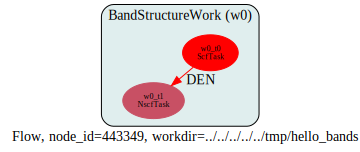

In [3]:
flow.get_graphviz()

<div class="alert alert-success" role="alert">
Note that we have not used `getden2 = -1` in the second dataset 
since AbiPy knows how to connect the two Tasks.
So no need for `get*` or `ird*` variables with Abipy. 
Just specify the correct dependency and python will do the rest!
</div>

To have useful information on the status of the flow, one uses:

In [4]:
flow.show_status()


Work #0: <BandStructureWork, node_id=443350, workdir=../../../../../tmp/hello_bands/w0>, Finalized=False
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| Task   | Status      | Queue   | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time   |   Node_ID |
+========+=============+=========+==============+============+==========+=================+========+===========+
| w0_t0  | Initialized | None    | 1|  1|2.0    | 2|  2      | ScfTask  | (0, 0, 0)       | None   |    443351 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| w0_t1  | Initialized | None    | 1|  1|2.0    | 1|  4      | NscfTask | (0, 0, 0)       | None   |    443352 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+



Meaning of the different columns:
    
   * *Task*: short name of the task (usually *w[index_of_work_in_flow]_t[index_of_task_in_work]*
   * *Status*: Status of the task
   * *Queue*: QueueName@Job identifier returned by the resource manager when the task is submitted
   * *(MPI|Omp|Gb)*: Number of MPI procs, OMP threads, and memory per MPI proc
   * *(Warn|Com)*: Number of Error/Warning/Comment messages found in the ABINIT log
   * *Class*: The class of the `Task`
   * *(Sub|Rest|Corr)*: Number of (submissions/restart/AbiPy corrections) performed
   * *Node_ID* : identifier of the task, used to select tasks or works in python code or `abirun.py`

Both `Flow` and `Work` are *iterable*. 
Iterating on a `Flow` gives `Work` objects, whereas
iterating over a `Work` gives the `Tasks` inside that particular `Work`.

```python
for work in flow:
    for task in work:
        print(task)
```

`Flows` and `Works` are containers and we can select items in these containers
with the syntax: flow[start:stop] or work[start:stop].
This means that the previous loop is equivalent to the much more verbose version: 

```python
for i in range(len(flow)):
    work = flow[i]
    for t in range(len(work):
        print(work[t])
```

At this point it should not be so difficult to understand that:

```python
flow[0][0]
```

gives the first task in the first work of the flow while

```python
flow[-1][-1]
```

selects the last `Task` in the last `Work`.
In several cases, we only need to iterate over a flat list of tasks without caring about the works.
In this case, we can use:

```python
for task in flow.iflat_tasks():
    print(task)
```

to iterate over all Tasks in the Flow.

## How to build and run the Flow

The flow is still in memory and no file has been produced. 
In order to build the workflow, use:

In [5]:
if os.path.isdir("/tmp/hello_bands/"): 
    import shutil
    shutil.rmtree("/tmp/hello_bands")

flow.build_and_pickle_dump()

0

This function creates the directories of the `Flow`:

(If you rely on MacOSX, the tree command might not be available. To fix this, see http://osxdaily.com/2016/09/09/view-folder-tree-terminal-mac-os-tree-equivalent/)

In [6]:
!tree /tmp/hello_bands

zsh:1: command not found: tree


Let's have a look at the files/directories associated to the first work (flow[0]):

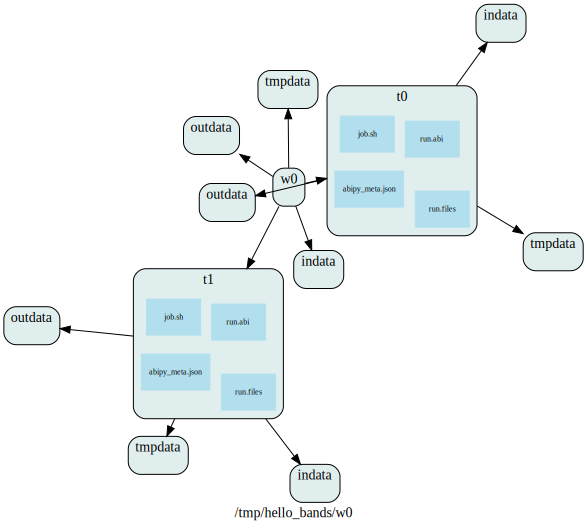

In [7]:
flow[0].get_graphviz_dirtree()

`w0` is the directory containing the input files of the first workflow (well, we have only one workflow in our example).
`t0` and `t1` contain the input files needed to run the SCF and the NSC run, respectively.

You might have noticed that each `Task` directory present the same structure:
    
   * *run.abi*: Input file
   * *run.files*: Files file
   * *job.sh*: Submission script
   * *outdata*: Directory containing output data files
   * *indata*: Directory containing input data files 
   * *tmpdata*: Directory with temporary files
   
<div class="alert alert-danger" role="alert">
`__AbinitFlow__.pickle` is the pickle file used to save the status of `Flow`. **Don't touch it!** 
</div>

An Abinit Task *has* an [AbinitInput](abinit_input.ipynb) which in turn has a [Structure](structure.ipynb):

In [8]:
 flow[0][0].input

<AbinitInput at 140366984762536>

In [9]:
flow[0][0].input.structure

Structure Summary
Lattice
    abc : 3.86697462 3.86697462 3.86697462
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 40.88829179346891
      A : 3.3488982567096763 0.0 1.9334873100000005
      B : 1.1162994189032256 3.1573715557642927 1.9334873100000005
      C : 0.0 0.0 3.86697462
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Si (1.1163, 0.7893, 1.9335) [0.2500, 0.2500, 0.2500]

In [10]:
for p in flow[0][0].input.pseudos: 
    print(p)

<NcAbinitPseudo: 14si.pspnc>
  summary: Troullier-Martins psp for element  Si        Thu Oct 27 17:31:21 EDT 1994
  number of valence electrons: 4.0
  maximum angular momentum: d
  angular momentum for local part: d
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 1.80626423934776
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0


Let's print the value of `kptopt` for all tasks in our flow with:

In [11]:
print([task.input["kptopt"] for task in flow.iflat_tasks()])

[1, -2]


that, in this particular case, gives the same result as:

In [12]:
print([task.input["kptopt"] for task in flow[0]])

[1, -2]


## Executing a Flow

The `Flow` can be executed with two different approaches: a programmatic interface based 
on `flow.make_scheduler` or the `abirun.py` script. 
In this section, we discuss the first approach because it plays well with the jupyter notebook.
Note however that `abirun.py` is highly recommended especially when running non-trivial calculations.

In [13]:
flow.make_scheduler().start()

Using scheduler v>=3.0.0


[Thu Jul  8 17:37:14 2021] Number of launches: 1

Work #0: <BandStructureWork, node_id=443350, workdir=../../../../../tmp/hello_bands/w0>, Finalized=False
+--------+-------------+------------+--------------+------------+----------+-----------------+----------+-----------+
| Task   | Status      | Queue      | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time     |   Node_ID |
+========+=============+============+==============+============+==========+=================+==========+===========+
| w0_t0  | Submitted   | 46006@gmac | 2|  1|2.0    | 0|  0      | ScfTask  | (1, 0, 0)       | 0:00:00Q |    443351 |
+--------+-------------+------------+--------------+------------+----------+-----------------+----------+-----------+
| w0_t1  | Initialized | None       | 1|  1|2.0    | NA|NA      | NscfTask | (0, 0, 0)       | None     |    443352 |
+--------+-------------+------------+--------------+------------+----------+-----------------+----------+-----------+



[Thu Jul  8 17:37:22 2021] Number of launches: 1

Work #0: <BandStructureWork, node_id=443350, workdir=../../../../../tmp/hello_bands/w0>, Finalized=False
+--------+-----------+------------+--------------+------------+----------+-----------------+----------+-----------+
| Task   | Status    | Queue      | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time     |   Node_ID |
+========+===========+============+==============+============+==========+=================+==========+===========+
| w0_t0  | Completed | 46006@gmac | 2|  1|2.0    | 2|  2      | ScfTask  | (1, 0, 0)       | 0:00:02R |    443351 |
+--------+-----------+------------+--------------+------------+----------+-----------------+----------+-----------+
| w0_t1  | Submitted | 46016@gmac | 2|  1|2.0    | 0|  0      | NscfTask | (1, 0, 0)       | 0:00:00Q |    443352 |
+--------+-----------+------------+--------------+------------+----------+-----------------+----------+-----------+




Work #0: <BandStructureWork, node_id=443350, workdir=../../../../../tmp/hello_bands/w0>, Finalized=True
  Finalized works are not shown. Use verbose > 0 to force output.

all_ok reached


Submitted on: Thu Jul  8 17:37:14 2021
Completed on: Thu Jul  8 17:37:30 2021
Elapsed time: 0:00:16.046165
Flow completed successfully

Calling flow.finalize()...


0

The flow keeps track of the different actions performed by the python code:

In [14]:
flow.show_history()


============== <BandStructureWork, node_id=443350, workdir=../../../../../tmp/hello_bands/w0> ==============
[Thu Jul  8 17:37:22 2021] In on_ok with sender <ScfTask, node_id=443351, workdir=../../../../../tmp/hello_bands/w0/t0>
[Thu Jul  8 17:37:30 2021] In on_ok with sender <NscfTask, node_id=443352, workdir=../../../../../tmp/hello_bands/w0/t1>
[Thu Jul  8 17:37:30 2021] Finalized set to True
[Thu Jul  8 17:37:30 2021] Work <BandStructureWork, node_id=443350, workdir=../../../../../tmp/hello_bands/w0> is finalized and broadcasts signal S_OK
[Thu Jul  8 17:37:30 2021] Node <BandStructureWork, node_id=443350, workdir=../../../../../tmp/hello_bands/w0> broadcasts signal Completed

================= <ScfTask, node_id=443351, workdir=../../../../../tmp/hello_bands/w0/t0> =================
[Thu Jul  8 17:37:14 2021] Status changed to Ready. msg: Status set to Ready
[Thu Jul  8 17:37:14 2021] Setting input variables: {'autoparal': 1, 'max_ncpus': 2, 'mem_test': 0}
[Thu Jul  8 17:37:14 202

If you read the logs carefully, you will realize that in the first iteration of the scheduler, 
only the `ScfTask` is executed because the second task depends on it. 
After the initial submission, the scheduler starts to monitor all the tasks in the flow.

When the ScfTask completes, the dependency of the NscfTask is fullfilled and 
a new submission takes place. Once the second task completes, the scheduler calls `flow.finalize`
to execute (optional) logic that is supposed to be executed to perform some sort of cleanup or final processing.
At this point, all the tasks in the flow are completed and the scheduler exits.

Now we can have a look at the different output files produced by our flow with:

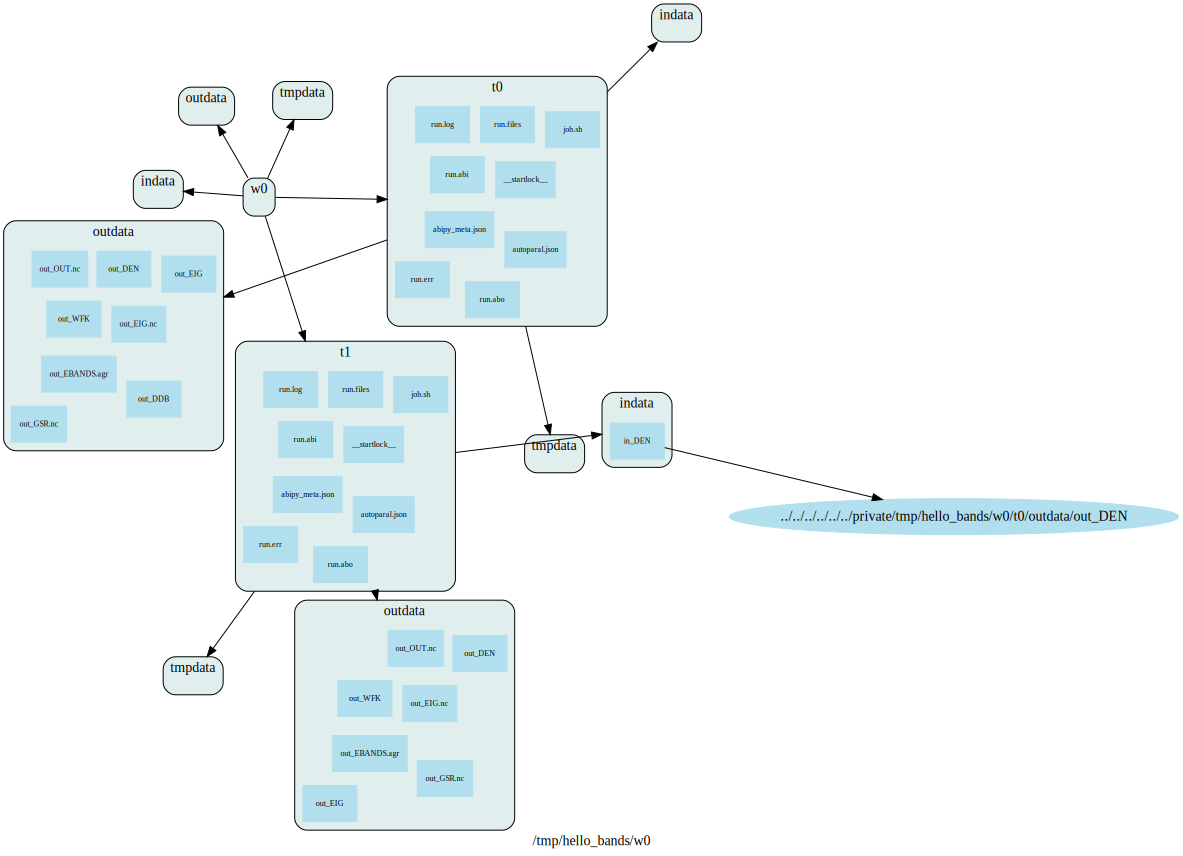

In [15]:
flow[0].get_graphviz_dirtree()

or list only the files with a given extension:

In [16]:
flow.listext("GSR.nc")

Found 2 files with extension `GSR.nc` produced by the flow
File                                                       Size [Mb]    Node_ID  Node Class
-------------------------------------------------------  -----------  ---------  ------------
../../../../../tmp/hello_bands/w0/t0/outdata/out_GSR.nc         1.99     443351  ScfTask
../../../../../tmp/hello_bands/w0/t1/outdata/out_GSR.nc         1.99     443352  NscfTask


The nice thing about the flow is that the object knows how to locate and interpret the 
different input/ouput files produced by Abinit. 
As a consequence, it is very easy to expose the AbiPy post-processing tools with a easy-to-use API
in which only tasks/works/flow plus a very few input arguments are required.

Let's call, for instance, the inspect method to plot the self-consistent cycles:

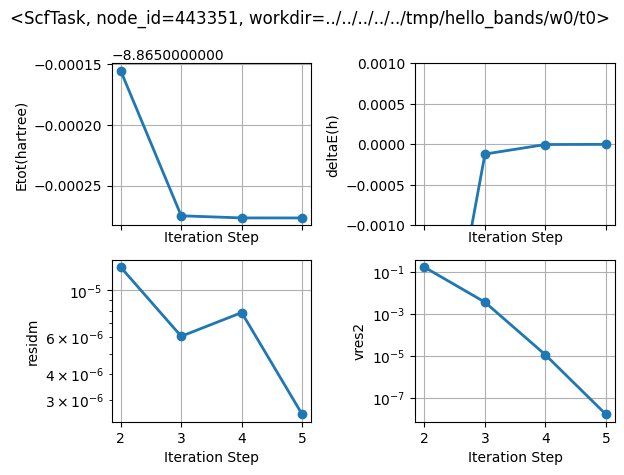

Task <NscfTask, node_id=443352, workdir=../../../../../tmp/hello_bands/w0/t1> does not provide an inspect method


In [17]:
flow.inspect(tight_layout=True);

In the other AbiPy tutorials, we have explained how to use abiopen to create 
python objects from netcdf files. 
Well, the same code can be reused with the flow. 
It is just a matter of replacing

```python
with abiopen(filepath) as gsr:
```

with

```python
with task.open_gsr() as gsr:
```

Note that there is no need to specify the file path when you use the task-based API, because 
the `Task` knows how to locate its `GSR.nc` output.
Let's do some practice...

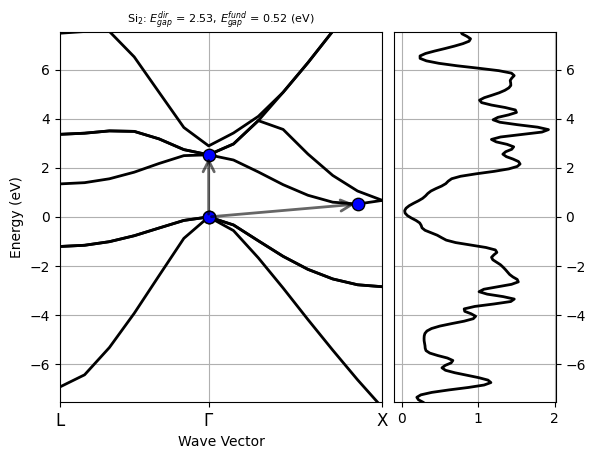

In [18]:
with flow[0][0].open_gsr() as gsr:
    ebands_kmesh = gsr.ebands
    
with flow[0][1].open_gsr() as gsr:
    gsr.ebands.plot_with_edos(ebands_kmesh.get_edos(), with_gaps=True);

## More on Works, Tasks and dependencies 

In the previous example, we have constructed a workflow for band structure calculations
starting from two input files and the magic line

```python
flow = flowtk.bandstructure_flow(workdir, scf_input, nscf_input)
```

Now it is the right time to explain in more details the syntax and the API used in AbiPy 
to build a flow with dependencies.
Let's try to build a `Flow` from scratch and use graphviz after each step to show what's happening.
We start with an empty flow in the `hello_flow` directory:

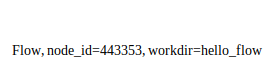

In [19]:
hello_flow = flowtk.Flow(workdir="hello_flow")
hello_flow.get_graphviz()

Now we add a new `Task` by just passing an `AbinitInput` for SCF calculations:

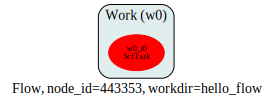

In [20]:
hello_flow.register_scf_task(scf_input, append=True)
hello_flow.get_graphviz()

Now the tricky part. 
We want to register a NSCF calculation that should depend on the `scf_task` in `w0_t0` via the DEN file.
We can use the same API but we **must** specify the dependency between the two steps with the 
```{scf_task: "DEN"}``` dictionary:

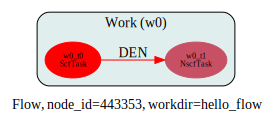

In [21]:
hello_flow.register_nscf_task(nscf_input, deps={hello_flow[0][0]: "DEN"}, append=True)
hello_flow.get_graphviz(engine="dot")

Excellent, we managed to build our first AbiPy flow with inter-dependent tasks in just six lines 
of code (including the three calls to graphviz).
Now let's assume we want to add a second Nscf calculation (`NscTask`) in which we change one of the input parameters
e.g. the number of bands and that, for some reason, we really want to re-use the output WFK file 
produced by `w0_t1` to initialize the eigenvalue solver (obviously we still need a DEN file).
How can we express this with AbiPy? 

Well, the syntax for the new deps, it's just:

```python
deps = {hello_flow[0][0]: "DEN", hello_flow[0][1]: "WFK"}
```

but we should also change the input variable nband in the `nscf_input` before creating
the new `NscTask` (remember that building a `Task` requires an `AbinitInput` object 
and a list of dependencies, if any).

Now there are two ways to increase nband: the **wrong** way and the **correct** one!
Let's start from the *wrong* way because it's always useful to learn from our mistakes.
Let's print some values just for the record:

In [22]:
t1 = flow[0][1]
print("nband in the first NscfTask:", t1.input["nband"])

nband in the first NscfTask: 8


Now let's use the "recipe" recommended to us by the FORTRAN guru of our group: 

<img src="https://github.com/abinit/abipy_assets/blob/master/Dont-Try-This-At-Home.jpg?raw=true" alt="">

In [23]:
# Just copy the previous input and change nband, it's super-easy, the FORTRAN guru said!
new_input = t1.input
new_input["nband"] = 1000

print("nband in the first NscfTask:", t1.input["nband"])
print("nband in the new input:", new_input["nband"])

nband in the first NscfTask: 1000
nband in the new input: 1000


Tada! Thanks to the trick of our beloved FORTRAN guru, we ended up with *two* NscfTaks
with the **same number** of bands (1000!). Why?

Because `AbinitInput` is implemented internally with a dictionary, python dictionaries are **mutable**
and python variables are essentially references (they do not store data, actually they store the address of the data).

In [24]:
a = {"foo": "bar"}
b = a 
c = a.copy()
a["hello"] = "world"
print("a dict:", a)
print("b dict:", b)
print("c dict:", c)

a dict: {'foo': 'bar', 'hello': 'world'}
b dict: {'foo': 'bar', 'hello': 'world'}
c dict: {'foo': 'bar'}


For a more techical explanation see [here](http://docs.python-guide.org/en/latest/writing/gotchas/)

To avoid this mistake, we need to *copy* the object before changing it

In [25]:
t1.input["nband"] = 8 # back to the old value

new_input = t1.input.new_with_vars(nband=1000)  # Copy and change nband

print("nband in the first NscfTask:", t1.input["nband"])
print("nband in the new input:", new_input["nband"])

nband in the first NscfTask: 8
nband in the new input: 1000


Now we can finally add the second `NscfTask` with 1000 bands:

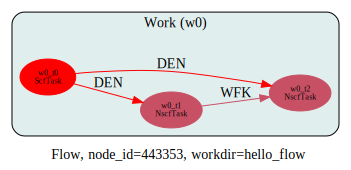

In [26]:
hello_flow.register_nscf_task(new_input, deps={hello_flow[0][0]: "DEN", hello_flow[0][1]: "WFK"}, append=True)
hello_flow.get_graphviz(engine="dot")

In [27]:
print([task.input["nband"] for task in hello_flow.iflat_tasks()])

[8, 8, 1000]


Note that AbiPy dependencies can also be fulfilled with external files that are already available
when the flow is constructed. There is no change in the syntax we've used so far.
It is just a matter of using the absolute path to the DEN file as keyword of the dictionary instead of a `Task`.
Let's start with a new `Flow` to avoid confusion and create a `NscfTask` that will start from a pre-computed `DEN` file.

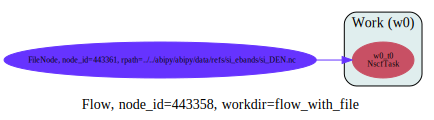

In [28]:
flow_with_file = flowtk.Flow(workdir="flow_with_file")

den_filepath = abidata.ref_file("si_DEN.nc")
flow_with_file.register_nscf_task(nscf_input, deps={den_filepath: "DEN"})

flow_with_file.get_graphviz(engine="dot")

A call to `new_with_vars` inside a python `for` loop is all we need to add other two `NscfTasks`
with different `nband`, all starting from the same DEN file:

[8, 10, 20]


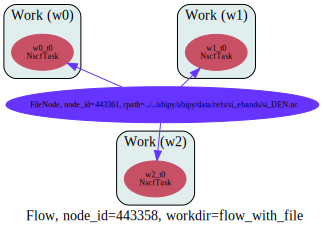

In [29]:
for nband in [10, 20]:
    flow_with_file.register_nscf_task(nscf_input.new_with_vars(nband=nband), 
                                      deps={den_filepath: "DEN"}, append=False)

print([task.input["nband"] for task in flow_with_file.iflat_tasks()])
flow_with_file.get_graphviz()

At this point, you may ask why we need `Works` since all the examples presented so far 
mainly involve the `Flow` object.

The answer is that `Works` allow us to encapsulate reusable logic in magic boxes 
that can perform lot of useful work. 
These boxes can then be connected together to generate more complicated workflows.
We have already encountered the `BandStructureWork` at the beginning of this lesson
and now it is time to introduce another fancy animal of the AbiPy zoo, the `PhononWork`.

In [30]:
abilab.print_doc(flowtk.PhononWork)

In [31]:
abilab.print_doc(flowtk.PhononWork.from_scf_task)

The docstring seems to suggest that if I have a `scf_task`, I can construct a magic box
to compute phonons but wait, I already have such a task! 
Actually I already have another magic box to compute the electronic band structure 
and it would be really great if I could compute the electronic and vibrational properties in a single flow.
Let's connect the two boxes together with:

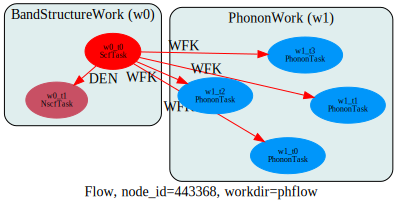

In [32]:
# Create new flow.
ph_flow = flowtk.Flow(workdir="phflow")

# Band structure (SCF + NSCF)
bands_work = flowtk.BandStructureWork(scf_input, nscf_input, dos_inputs=None)
ph_flow.register_work(bands_work)    
    
# Build second work from scf_task.
scf_task = bands_work[0]
ph_work = flowtk.PhononWork.from_scf_task(scf_task, [2, 2, 2], is_ngqpt=True, tolerance=None)
ph_flow.register_work(ph_work) 

ph_flow.get_graphviz()

Now it turns out that the `PhononWork` merges all the DDB files produced by its `PhononTask`
and put this final output file in its outdir. 
So from the AbiPy perspective, a `PhononWork` is not that different from a `ScfTask` that produces e.g. a DEN file.
This means that we can connect other magic boxes to our `PhononWork` e.g. a set of `EPhTasks` that 
require a DDB file and another input file with the DFPT potentials 
(DVDB, merged by `PhononWork` similarly to what is done for the DDB).

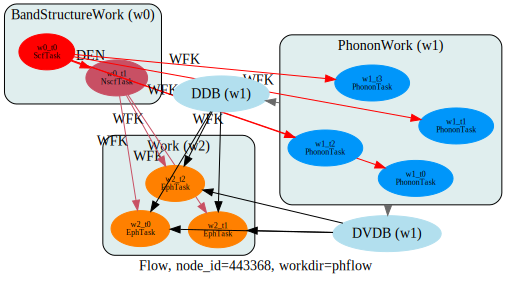

In [33]:
# EPH tasks require 3 input files (WFK, DDB, DVDB)
eph_deps = {ph_flow[0][1]: "WFK", ph_work: ["DDB", "DVDB"]}

for i, ecut in enumerate([2, 3, 4]):
    ph_flow.register_eph_task(nscf_input.new_with_vars(ecut=ecut), deps=eph_deps, append=(i != 0))
                           
ph_flow.get_graphviz()

This explains why in AbiPy we have this classification in terms of `Tasks/Works/Flows`.
As a consequence, we can implement highly specialized `Works/Tasks` to
solve specific problems and then connect all these nodes together.
Just 11 lines of code to get electrons + phonons + (electrons + phononons)!

But wait, did you see the gorilla?

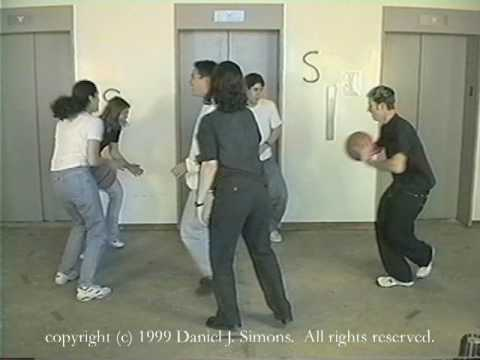

In [34]:
from IPython.display import YouTubeVideo
YouTubeVideo("vJG698U2Mvo")

There's indeed a bug in the last step. The connections among the nodes are OK but we made
a mistake while creating the `EPhTasks` with:

```python
ph_flow.register_eph_task(nscf_input.new_with_vars(ecut=ecut), ...)
```

because we passed an input for a standard band structure calculation to something that is supposed
to deal with E-PH interaction.
This essentially to stress that the AbiPy `Flow`, *by design*, does not try to validate your input to make sure
it is consistent with the workflow logic.
This is done on purpose for two reasons:

- Expert users should be able to customize/tune their input files and validating all the possible cases in python is not trivial
- Only Abinit (and God) knows at run-time if your input file makes sense and we can't reimplement the same logic in python

At this point, you may wonder why we have so many different Abipy Tasks (`ScfTask`, `NscfTask`, `RelaxTask`, `PhononTask`, `EPHTask` ...) if there's no input validation when we create them...

The answer is that we need all these subclasses to implement extra logic that is specific to that particular calculation. Abipy, indeed, is not just submitting jobs. It also monitors the evolution of the calculation
and execute pre-defined code to fix run-time problems (and these problems are calculation specific).
An example will help clarify this point.

Restarting jobs is one of the typical problem encountered in ab-initio calculations
and restarting a `RelaxTask` requires a different logic from e.g. restarting a `ScfTask`.
In the case of a `ScfTask` we only need to use the output WFK (DEN) of the previous execution 
as input of the restarted job while a `RelaxTask` must also re-use the (unconverged) final structure 
of the previous job to be effective and avoid a possibly infinite loop.
In a nutshell, when you are using a particular `Task/Work` class you are telling AbiPy how to handle possible
problems at run-time and you are also specifying the actions that should be performed 
at the beginning/end of the execution.

## Abirun.py

Executing 

```python 
flow.make_scheduler().start()
``` 

inside a jupyter notebook is handy if you are dealing with small calculations that require few seconds or minutes. 
This approach, however, is unpractical when you have large flows or big calculations requiring hours or days, 
even on massively parallel machines.
In this case, indeed, one would like to run the scheduler in a separate process in the backgroud 
so that the scheduler is not killed when the jupyter server is closed.

To start the scheduler in a separate process, use the `abirun.py` script.
The syntax is:

    abirun.py flow_workdir COMMAND

where `flow_workdir` is the directory containing the `Flow` 
(the directory with the pickle file) and `command` selects the operation to be performed.

Typical examples:

    abirun.py /tmp/hello_bands status
    
checks the status of the `Flow` and print the results to screen while

    nohup abirun.py /tmp/hello_bands scheduler > sched.log 2> sched.err &
    
starts the scheduler in the background redirecting the standard output to file `sched.log`

<div class="alert alert-success">
`nohup` is a standard Unix tool. The command make the scheduler immune 
to hangups so that you can close the shell session without killing the scheduler.
</div>

This brings us to the last and most crucial question. 
How do we configure AbiPy to run Abinit workflows on different architectures ranging from 
standard laptops to high-performance supercomputers?

Unfortunately this notebook is already quite long and these details are best covered 
in a technical documentation.
What should be stressed here is that the behaviour can be customized with two Yaml files.
All the information related to your environment (Abinit build, modules, resource managers, shell environment)
are read from the `manager.yml` configuration file, that is usually located in the directory `~/.abinit/abipy/`
The options for the python scheduler responsible for job submission are given in `scheduler.yml`.

For a more complete description of these configuration options, 
please consult the [TaskManager documentation](http://abinit.github.io/abipy/workflows/taskmanager.html).
A list of configuration files for different machines and clusters is available 
[here](http://abinit.github.io/abipy/workflows/manager_examples.html)
while the [Flows HOWTO](http://abinit.github.io/abipy/flows_howto.html)
gathers answers to frequently asked questions.

Last but not least, check out our 
[gallery of AbiPy Flows](http://abinit.github.io/abipy/flow_gallery/index.html) for inspiration.